In [74]:
!pip install tensorflow word2vec nbqa pylint 

In [2]:
import spacy
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
#import unicodedata
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
# import gensim

nlp = spacy.load("en_core_web_sm")
from tensorflow.keras.layers import Embedding
from sklearn.metrics import classification_report

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('up')
stopword_list.remove('down')

[nltk_data] Downloading package stopwords to /home/jeremy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('./data/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [4]:
df.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


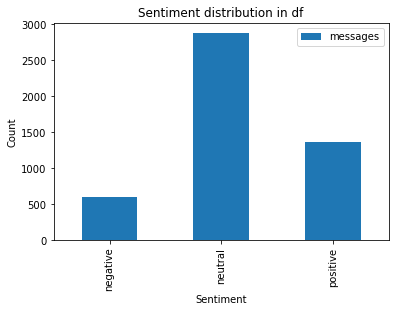

In [5]:
df.groupby(['labels']).count().plot.bar()
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment distribution in df")
plt.show()

In [6]:
### remove stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [7]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [8]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("Returning books is something I remain thinking about") #odd sentence, I know

'return book be something I remain think about'

In [9]:
def normalize_text(text):
    exp = expand_contractions(text)
    low = exp.lower()
    lemm = lemmatize_text(low)
    no_sw = remove_stopwords(lemm)
    return simple_preprocess(no_sw)

In [10]:
#### text preprocess:

df['messages'] = [normalize_text(row) for row in df['messages']]

In [11]:
df.iloc[0]['messages'][:3]

['accord', 'gran', 'company']

In [12]:
### map sentiment to int:

def map_sentiment(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'neutral':
        return 1
    else:
        return 2

In [13]:
df['labels'] = [map_sentiment(row) for row in df['labels']]

In [14]:
df['labels'].head(3)

0    1
1    1
2    0
Name: labels, dtype: int64

Number of rows per sentiment:
1    2879
2    1363
0     604
Name: labels, dtype: int64


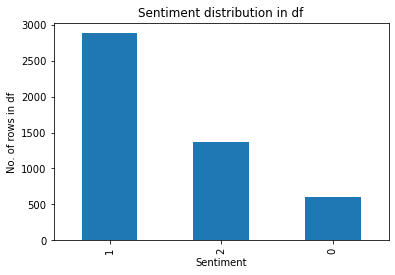

In [15]:
print("Number of rows per sentiment:")
print(df['labels'].value_counts())

plt.figure()
pd.value_counts(df['labels']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [16]:
df.to_csv('preprocessed-text.csv', sep = ',')

In [17]:
# prep for word2vec generation

In [18]:
df[['messages']].head()

,messages
0,"[accord, gran, company, no, plan, move, produc..."
1,"[technopoli, plan, develop, stage, area, no, l..."
2,"[international, electronic, industry, company,..."
3,"[new, production, plant, company, would, incre..."
4,"[accord, company, update, strategy, year, basw..."


In [19]:
corpus = pd.Series(df['messages'].values)

In [20]:
from gensim.models import Word2Vec

In [21]:
# init word2vec class
w2v_model = Word2Vec(corpus,
                     vector_size=300, # 300 dimension vector
                     window=15, # how many neighbors around a particular word
                     min_count=2, # the word needs to appear at least two times in the corpus
                     workers=20, # speed of training
                     sg=1, # sg=1 means this is a skip-gram model
                     negative=5, # num of negative samples
                     sample=1e-5) # sampling rate

In [22]:
words = set(w2v_model.wv.index_to_key )

In [23]:
# word_vec_dict={}
# for word in words:
#     word_vec_dict[word]=w2v_model.wv.get_vector(word)
# print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

### Keras Sentence Tokenizer

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [25]:
tokenizer= Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(df.messages.values)

In [26]:
word_index = tokenizer.word_index

In [27]:
print(word_index['short'])

684


In [28]:
len(word_index)

7404

In [29]:
df['keras_tokens'] = df['messages'].apply(tokenizer.texts_to_sequences)

In [30]:
type(df.keras_tokens[0][0])

list

In [31]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [32]:
test_sentence1 = list(traverse(df.keras_tokens[0]))
test_sentence1

[62, 2674, 3, 194, 80, 360, 54, 102, 2156, 3, 143]

In [33]:
df['keras_tokens'] = df['keras_tokens'].apply(traverse).apply(list)

In [34]:
df.head(2)

,labels,messages,keras_tokens
0,1,"[accord, gran, company, no, plan, move, produc...","[62, 2674, 3, 194, 80, 360, 54, 102, 2156, 3, ..."
1,1,"[technopoli, plan, develop, stage, area, no, l...","[930, 80, 103, 931, 88, 194, 866, 483, 1282, 3..."


### Train Test Split

In [35]:
df.head(2)

,labels,messages,keras_tokens
0,1,"[accord, gran, company, no, plan, move, produc...","[62, 2674, 3, 194, 80, 360, 54, 102, 2156, 3, ..."
1,1,"[technopoli, plan, develop, stage, area, no, l...","[930, 80, 103, 931, 88, 194, 866, 483, 1282, 3..."


In [36]:
print(len(df.keras_tokens.values))

4846


In [37]:
print(len(df.labels.values))

4846


In [38]:
X_keras = df.keras_tokens.values
y = df.labels.values

In [39]:
X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X_keras, y, test_size=.3, random_state=42)


print(X_train_keras.shape, X_test_keras.shape)

(3392,) (1454,)


## Pad Sequences

In [40]:
padded_train_seq = pad_sequences(X_train_keras, maxlen=50, padding='post')
padded_test_seq = pad_sequences(X_test_keras, maxlen=50, padding='post')

In [41]:
print(padded_train_seq.shape)
print(y_train_keras.shape)
print(padded_test_seq.shape)
print(y_test_keras.shape)

(3392, 50)
(3392,)
(1454, 50)
(1454,)


### Basic Sentiment Network Using Word2Vec Embedding Layer

In [42]:
vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]

In [43]:
model = tf.keras.Sequential([
    Embedding(input_dim=15000,
                  output_dim=300,
                  input_length=50),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(3, activation = tf.nn.softmax)
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           4500000   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 60)                18060     
                                                                 
 dense_1 (Dense)             (None, 3)                 183       
                                                                 
Total params: 4,518,243
Trainable params: 4,518,243
Non-trainable params: 0
_________________________________________________________________


In [44]:
len(padded_train_seq)

3392

### Run the Model

In [45]:
num_epochs = 10
model.fit(padded_train_seq, y_train_keras, epochs=num_epochs, validation_data=(padded_test_seq, y_test_keras))

Epoch 1/10
106/106 [==============================] - 5s 45ms/step - loss: 0.9047 - accuracy: 0.5943 - val_loss: 0.8494 - val_accuracy: 0.5846
Epoch 2/10
106/106 [==============================] - 5s 43ms/step - loss: 0.6562 - accuracy: 0.7129 - val_loss: 0.6359 - val_accuracy: 0.7387
Epoch 3/10
106/106 [==============================] - 4s 41ms/step - loss: 0.3177 - accuracy: 0.8906 - val_loss: 0.5965 - val_accuracy: 0.7607
Epoch 4/10
106/106 [==============================] - 4s 41ms/step - loss: 0.1285 - accuracy: 0.9673 - val_loss: 0.6501 - val_accuracy: 0.7565
Epoch 5/10
106/106 [==============================] - 4s 37ms/step - loss: 0.0503 - accuracy: 0.9915 - val_loss: 0.6737 - val_accuracy: 0.7600
Epoch 6/10
106/106 [==============================] - 4s 39ms/step - loss: 0.0249 - accuracy: 0.9959 - val_loss: 0.7093 - val_accuracy: 0.7620
Epoch 7/10
106/106 [==============================] - 4s 42ms/step - loss: 0.0157 - accuracy: 0.9976 - val_loss: 0.7531 - val_accuracy: 0.7620

In [46]:
y_pred = model.predict(padded_test_seq)

46/46 [==============================] - 0s 2ms/step


In [47]:
y_pred_max = np.argmax(y_pred, axis=1)

In [48]:
print(classification_report(y_test_keras,y_pred_max, zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71       179
           1       0.80      0.84      0.82       847
           2       0.68      0.65      0.67       428

    accuracy                           0.76      1454
   macro avg       0.75      0.72      0.73      1454
weighted avg       0.76      0.76      0.76      1454



In [49]:
!nbqa pylint 2_data-wrangling_jeremy_version.ipynb | grep unused

In [75]:
!pip freeze >> requirements.txt